In [1]:
import pandas as pd
import numpy as np

import source.utility as ut
import source.transf_univ as df_p
import source.report as rp
from source.validate import random_split, yearly_split

from sklearn.model_selection import KFold
from scipy.interpolate import UnivariateSpline

from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_columns', 300)

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

In [2]:
df = pd.read_csv('data/processed_women/training_data.csv')

df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T1_FGM2,T1_FGA2,T1_Tot_Reb,T1_FGM_no_ast,T1_possessions,T1_off_rating,T1_scoring_opp,T1_TO_perposs,T1_def_rating,T1_impact,T1_Def_effort,T1_Reb_opp,T1_Score_diff,T1_FGM_diff,T1_FGA_diff,T1_FGM3_diff,T1_FGA3_diff,T1_FTM_diff,T1_FTA_diff,T1_OR_diff,T1_DR_diff,T1_Ast_diff,T1_TO_diff,T1_Stl_diff,T1_Blk_diff,T1_PF_diff,T1_FGM2_diff,T1_FGA2_diff,T1_Tot_Reb_diff,T1_FGM_no_ast_diff,T1_Def_effort_diff,T1_Reb_opp_diff,T1_possessions_diff,T1_off_rating_diff,T1_def_rating_diff,T1_scoring_opp_diff,T1_TO_perposs_diff,T1_impact_diff,T1_N_wins,T1_FGM_perc,T1_FGM2_perc,T1_FGM3_perc,T1_FT_perc,T1_FGM_no_ast_perc,T1_L2W_Score,T1_L2W_FGM,T1_L2W_FGA,T1_L2W_FGM3,T1_L2W_FGA3,T1_L2W_FTM,T1_L2W_FTA,T1_L2W_OR,T1_L2W_DR,T1_L2W_Ast,T1_L2W_TO,T1_L2W_Stl,T1_L2W_Blk,T1_L2W_PF,T1_L2W_FGM2,T1_L2W_FGA2,T1_L2W_Tot_Reb,T1_L2W_FGM_no_ast,T1_L2W_possessions,T1_L2W_off_rating,T1_L2W_scoring_opp,T1_L2W_TO_perposs,T1_L2W_def_rating,T1_L2W_impact,T1_L2W_Def_effort,T1_L2W_Reb_opp,T1_L2W_Score_diff,T1_L2W_FGM_diff,T1_L2W_FGA_diff,T1_L2W_FGM3_diff,T1_L2W_FGA3_diff,T1_L2W_FTM_diff,T1_L2W_FTA_diff,T1_L2W_OR_diff,T1_L2W_DR_diff,T1_L2W_Ast_diff,T1_L2W_TO_diff,T1_L2W_Stl_diff,T1_L2W_Blk_diff,T1_L2W_PF_diff,T1_L2W_FGM2_diff,T1_L2W_FGA2_diff,T1_L2W_Tot_Reb_diff,T1_L2W_FGM_no_ast_diff,T1_L2W_Def_effort_diff,T1_L2W_Reb_opp_diff,T1_L2W_possessions_diff,T1_L2W_off_rating_diff,T1_L2W_def_rating_diff,T1_L2W_scoring_opp_diff,T1_L2W_TO_perposs_diff,T1_L2W_impact_diff,T1_L2W_N_wins,T1_L2W_FGM_perc,T1_L2W_FGM2_perc,T1_L2W_FGM3_perc,T1_L2W_FT_perc,T1_L2W_FGM_no_ast_perc,T1_Seed,T2_Score,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T2_FGM2,T2_FGA2,T2_Tot_Reb,T2_FGM_no_ast,T2_possessions,T2_off_rating,T2_scoring_opp,T2_TO_perposs,T2_def_rating,T2_impact,...,T2_L2W_FGM_diff,T2_L2W_FGA_diff,T2_L2W_FGM3_diff,T2_L2W_FGA3_diff,T2_L2W_FTM_diff,T2_L2W_FTA_diff,T2_L2W_OR_diff,T2_L2W_DR_diff,T2_L2W_Ast_diff,T2_L2W_TO_diff,T2_L2W_Stl_diff,T2_L2W_Blk_diff,T2_L2W_PF_diff,T2_L2W_FGM2_diff,T2_L2W_FGA2_diff,T2_L2W_Tot_Reb_diff,T2_L2W_FGM_no_ast_diff,T2_L2W_Def_effort_diff,T2_L2W_Reb_opp_diff,T2_L2W_possessions_diff,T2_L2W_off_rating_diff,T2_L2W_def_rating_diff,T2_L2W_scoring_opp_diff,T2_L2W_TO_perposs_diff,T2_L2W_impact_diff,T2_L2W_N_wins,T2_L2W_FGM_perc,T2_L2W_FGM2_perc,T2_L2W_FGM3_perc,T2_L2W_FT_perc,T2_L2W_FGM_no_ast_perc,T2_Seed,delta_Loc,delta_Score,delta_FGM,delta_FGA,delta_FGM3,delta_FGA3,delta_FTM,delta_FTA,delta_OR,delta_DR,delta_Ast,delta_TO,delta_Stl,delta_Blk,delta_PF,delta_FGM2,delta_FGA2,delta_Tot_Reb,delta_FGM_no_ast,delta_possessions,delta_off_rating,delta_scoring_opp,delta_TO_perposs,delta_def_rating,delta_impact,delta_Def_effort,delta_Reb_opp,delta_Score_diff,delta_FGM_diff,delta_FGA_diff,delta_FGM3_diff,delta_FGA3_diff,delta_FTM_diff,delta_FTA_diff,delta_OR_diff,delta_DR_diff,delta_Ast_diff,delta_TO_diff,delta_Stl_diff,delta_Blk_diff,delta_PF_diff,delta_FGM2_diff,delta_FGA2_diff,delta_Tot_Reb_diff,delta_FGM_no_ast_diff,delta_Def_effort_diff,delta_Reb_opp_diff,delta_possessions_diff,delta_off_rating_diff,delta_def_rating_diff,delta_scoring_opp_diff,delta_TO_perposs_diff,delta_impact_diff,delta_N_wins,delta_FGM_perc,delta_FGM2_perc,delta_FGM3_perc,delta_FT_perc,delta_FGM_no_ast_perc,delta_L2W_Score,delta_L2W_FGM,delta_L2W_FGA,delta_L2W_FGM3,delta_L2W_FGA3,delta_L2W_FTM,delta_L2W_FTA,delta_L2W_OR,delta_L2W_DR,delta_L2W_Ast,delta_L2W_TO,delta_L2W_Stl,delta_L2W_Blk,delta_L2W_PF,delta_L2W_FGM2,delta_L2W_FGA2,delta_L2W_Tot_Reb,delta_L2W_FGM_no_ast,delta_L2W_possessions,delta_L2W_off_rating,delta_L2W_scoring_opp,delta_L2W_TO_perposs,delta_L2W_def_rating,delta_L2W_impact,delta_L2W_Def_effort,delta_L2W_Reb_opp,delta_L2W_Score_diff,delta_L2W_FGM_diff,delta_L2W_FGA_diff,delta_L2W_FGM3_diff,delta_L2W_FGA3_diff,delta_L2W_FTM_diff,delta_L2W_FTA_diff,delta_L2W_OR_diff,delta_L2W_DR_diff,delta_L2W_Ast

In [3]:
standard = ['Season', 'target', 'target_points', 'ID']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

feat_dict = {'l2w': l2w, 'tot': tot, 'l2w_delta': l2w_deltas, 'tot_delta': tot_deltas}

models = [('lasso', Lasso(alpha=0.1)), 
          ('ridge', Ridge()), 
          ('forest', RandomForestRegressor(n_estimators=200, n_jobs=5)), ('xtree', ExtraTreesRegressor(n_estimators=200, n_jobs=5)), 
          ('xgb', XGBRegressor(n_estimators=100, objective='reg:squarederror'))]

for model in models:
    print('_'*40)
    print(model[0])
    for feats in feat_dict.keys():
        print(f'\t {feats}')
        print('\t'+'-'*30)
        df_train = df[standard + feat_dict[feats]]
        
        pipe = Pipeline([('scl', df_p.df_scaler())] + [model])
        
        fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')
        
        rp.report_points(train, test, y_train, y_test, oof_pred, test_pred, plot=False)
        print('\t'+'-'*30)
    print('_'*40)

________________________________________
lasso
	 l2w
	------------------------------
MAE train: 			 13.8105
MAE test: 			 15.1821
RMSE train: 			 17.4357
RMSE test: 			 19.8434
Accuracy train: 		 0.6964
Accuracy test: 			 0.623
Logloss train: 			 0.5817
Logloss test: 			 0.619
Unsure train: 			 6.85%
Unsure test: 			 9.52%
	------------------------------
	 tot
	------------------------------
MAE train: 			 9.6414
MAE test: 			 10.6548
RMSE train: 			 12.233
RMSE test: 			 13.3918
Accuracy train: 		 0.8075
Accuracy test: 			 0.7579
Logloss train: 			 0.4163
Logloss test: 			 0.4818
Unsure train: 			 5.65%
Unsure test: 			 7.54%
	------------------------------
	 l2w_delta
	------------------------------
MAE train: 			 13.5166
MAE test: 			 14.9475
RMSE train: 			 17.1183
RMSE test: 			 19.4619
Accuracy train: 		 0.7004
Accuracy test: 			 0.6508
Logloss train: 			 0.5715
Logloss test: 			 0.6073
Unsure train: 			 6.45%
Unsure test: 			 9.13%
	------------------------------
	 tot_delta
	--

/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 14.1688
MAE test: 			 15.4772
RMSE train: 			 17.6343
RMSE test: 			 20.0028
Accuracy train: 		 0.6577
Accuracy test: 			 0.6508
Logloss train: 			 0.6035
Logloss test: 			 0.6367
Unsure train: 			 8.53%
Unsure test: 			 11.9%
	------------------------------
	 tot
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 10.1703
MAE test: 			 11.4798
RMSE train: 			 12.7326
RMSE test: 			 14.1799
Accuracy train: 		 0.7917
Accuracy test: 			 0.746
Logloss train: 			 0.434
Logloss test: 			 0.5039
Unsure train: 			 4.96%
Unsure test: 			 7.14%
	------------------------------
	 l2w_delta
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 14.6129
MAE test: 			 16.6685
RMSE train: 			 18.1975
RMSE test: 			 21.386
Accuracy train: 		 0.6716
Accuracy test: 			 0.6111
Logloss train: 			 0.6203
Logloss test: 			 0.6616
Unsure train: 			 7.14%
Unsure test: 			 11.11%
	------------------------------
	 tot_delta
	------------------------------


/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/lucabasa/Git/kaggle_competitions/marc_madness/ncaa/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE train: 			 10.0249
MAE test: 			 11.3675
RMSE train: 			 12.4968
RMSE test: 			 14.0747
Accuracy train: 		 0.7976
Accuracy test: 			 0.7421
Logloss train: 			 0.4334
Logloss test: 			 0.5042
Unsure train: 			 4.96%
Unsure test: 			 5.56%
	------------------------------
________________________________________


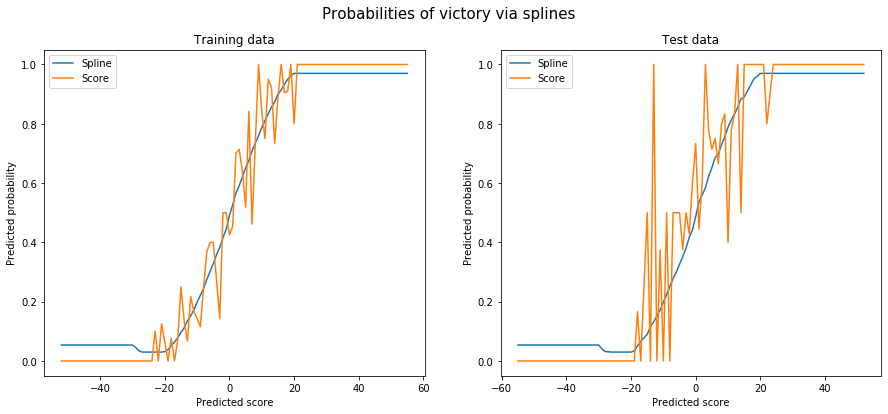

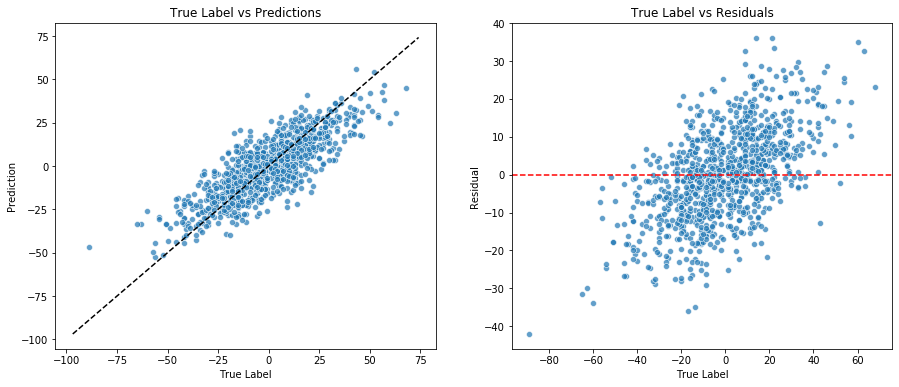

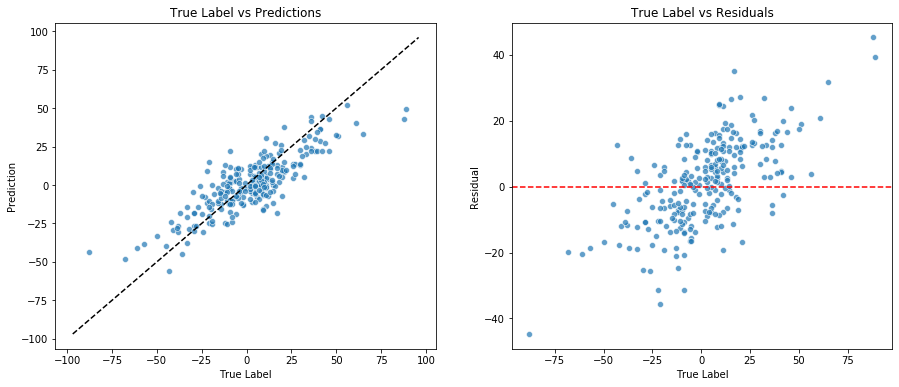

MAE train: 			 9.4494
MAE test: 			 10.493
RMSE train: 			 12.02
RMSE test: 			 13.1618
Accuracy train: 		 0.8056
Accuracy test: 			 0.7619
Logloss train: 			 0.4094
Logloss test: 			 0.4696
Unsure train: 			 4.66%
Unsure test: 			 5.95%


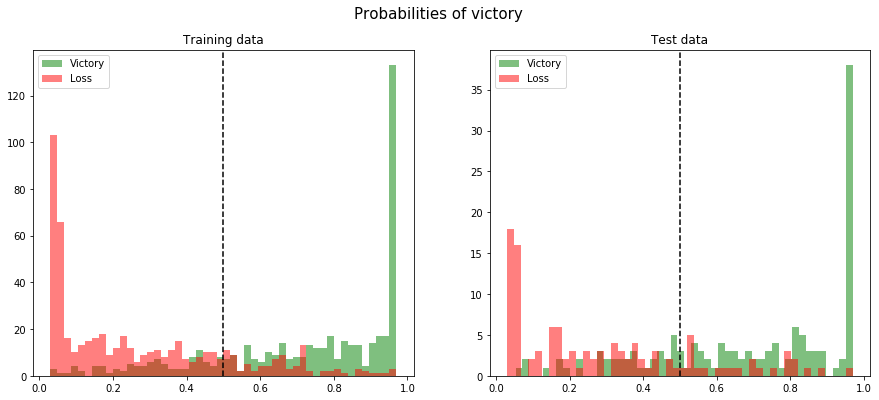

In [5]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('lasso', Lasso(alpha=0.1))])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')

rp.report_points(train, test, y_train, y_test, oof_pred, test_pred)